
# Modelo CNN 2D para Previsão de Tendência (Imagens) - VALE3.SA

**Objetivo:** Este notebook implementa e avalia um modelo de Rede Neural Convolucional 2D (CNN 2D) para prever a tendência (Compra/Venda) da ação VALE3.SA, utilizando as **imagens** dos gráficos de barras dos últimos 15 dias como entrada.

**Contexto:** Exploração do uso de representações visuais (imagens) dos dados de mercado como alternativa às features numéricas tabulares, utilizando uma arquitetura CNN 2D com hiperparâmetros ajustados via Keras Tuner.

**Metodologia:**
1.  **Carregamento de Dados:** Utilização do `image_dataset_from_directory` para carregar as imagens das pastas `treino` e `teste`, separadas em subpastas `comprar` e `vender`.
2.  **Pré-processamento de Imagens:** Redimensionamento das imagens para um tamanho padrão (100x333), conversão para tons de cinza e normalização dos valores dos pixels para o intervalo [0, 1].
3.  **Modelo CNN 2D :** Construção do modelo CNN 2D utilizando os **melhores hiperparâmetros** encontrados via Keras Tuner (detalhados na seção de construção do modelo). A arquitetura inclui 3 blocos convolucionais.
4.  **Treinamento:** Treinamento do modelo com os datasets de imagens, utilizando Early Stopping monitorando `val_auc`.
5.  **Avaliação:** Análise detalhada do desempenho no conjunto de teste de imagens.
6.  **Visualização:** Geração de gráficos de treinamento e desempenho.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
# Camadas específicas para CNN 2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam # Usando legacy Adam conforme necessidade
from tensorflow.keras.preprocessing import image_dataset_from_directory # Para carregar imagens
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import os
import time # Para medir o tempo

# Configurações básicas
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

# --- Configuração do Dispositivo ---
print("Configurando dispositivo TensorFlow...")
try:
    if tf.config.list_physical_devices('GPU'):
        print("GPU disponível. Usando TensorFlow com GPU.")
    elif hasattr(tf.config, 'list_physical_devices') and tf.config.list_physical_devices('MPS'):
         print("Apple MPS disponível. Usando TensorFlow com MPS.")
    else:
        print("Nenhuma GPU ou MPS detectada. Usando TensorFlow em CPU.")
except Exception as e:
    print(f"Erro ao configurar dispositivos: {e}. Usando configuração padrão.")

Configurando dispositivo TensorFlow...
GPU disponível. Usando TensorFlow com GPU.



## 1. Carregamento e Pré-processamento das Imagens

Definimos os parâmetros para o carregamento das imagens (diretórios, tamanho, modo de cor) e utilizamos a função `image_dataset_from_directory` do Keras para criar datasets de treino e teste.

As imagens são redimensionadas para 100x333 pixels, convertidas para tons de cinza (1 canal) e os valores dos pixels são normalizados para o intervalo [0, 1] usando uma camada `Rescaling`. Otimizamos os datasets com `cache()` e `prefetch()` para melhor performance de I/O durante o treinamento.


Carregando imagens de treino de: ../data/VALE3.SA/imagens/treino
Found 4808 files belonging to 2 classes.


2025-04-26 11:03:33.339987: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 11:03:33.340036: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 11:03:33.340047: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-26 11:03:33.340187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 11:03:33.340862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Carregando imagens de teste de: ../data/VALE3.SA/imagens/teste
Found 1203 files belonging to 2 classes.
Classes encontradas: ['comprar', 'vender']

Exibindo amostra das imagens de treino...


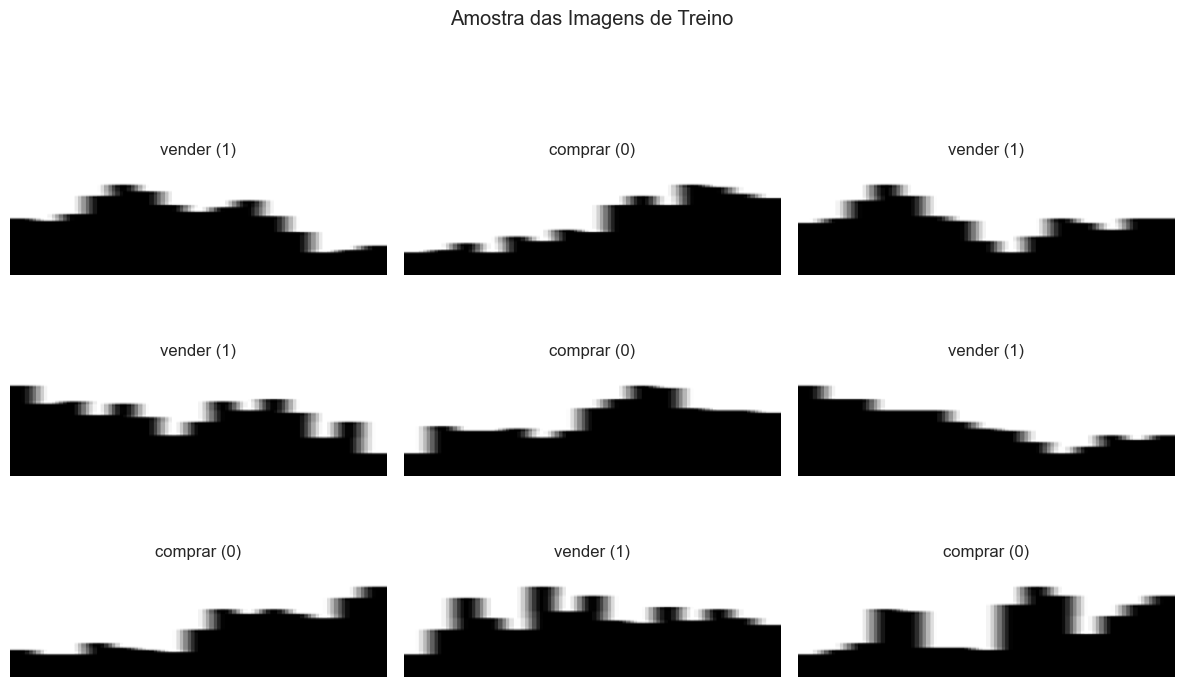


Normalizando e otimizando datasets...
Datasets prontos para treinamento.


In [2]:
# --- Parâmetros ---
IMAGE_DIR = '../data/VALE3.SA/imagens/' # Diretório raiz das imagens
TRAIN_DIR = os.path.join(IMAGE_DIR, 'treino')
TEST_DIR = os.path.join(IMAGE_DIR, 'teste')
IMAGE_HEIGHT = 100 # Altura original/desejada
IMAGE_WIDTH = 333  # Largura original/desejada
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32
COLOR_MODE = 'grayscale'
CHANNELS = 1 if COLOR_MODE == 'grayscale' else 3
SEED = 42 # Para reprodutibilidade do shuffle no treino

# --- Carregamento ---
print(f"Carregando imagens de treino de: {TRAIN_DIR}")
try:
    train_dataset = image_dataset_from_directory(
        TRAIN_DIR,
        labels='inferred',
        label_mode='binary', # Saída 0 ou 1
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed=SEED
    )
    print(f"Carregando imagens de teste de: {TEST_DIR}")
    test_dataset = image_dataset_from_directory(
        TEST_DIR,
        labels='inferred',
        label_mode='binary',
        image_size=IMAGE_SIZE,
        interpolation='nearest',
        batch_size=BATCH_SIZE,
        color_mode=COLOR_MODE,
        shuffle=False, # Não embaralhar teste
        seed=SEED
    )

    # CORREÇÃO: Acessar apenas class_names. O mapeamento geralmente é alfabético.
    class_names = train_dataset.class_names
    print(f"Classes encontradas: {class_names}")
    # Exemplo: Se class_names for ['comprar', 'vender'], então 'comprar' é 0 e 'vender' é 1.
    # Se for ['vender', 'comprar'], então 'vender' é 0 e 'comprar' é 1.
    # Ajuste a interpretação dos resultados se necessário.

    # --- Visualização Opcional ---
    print("\nExibindo amostra das imagens de treino...")
    plt.figure(figsize=(12, 8)) # Ajustar tamanho se necessário
    for images, labels in train_dataset.take(1): # Pega um lote
        for i in range(min(9, BATCH_SIZE)): # Mostra até 9 imagens
            ax = plt.subplot(3, 3, i + 1)
            img_display = np.squeeze(images[i].numpy()) # Remove dimensão do canal
            plt.imshow(img_display.astype("uint8"), cmap='gray')
            label_idx = int(labels[i].numpy())
            # Usa class_names para mostrar o nome da classe
            plt.title(f"{class_names[label_idx]} ({label_idx})")
            plt.axis("off")
    plt.suptitle("Amostra das Imagens de Treino")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout com suptitle
    plt.show()

    # --- Pré-processamento e Otimização ---
    print("\nNormalizando e otimizando datasets...")
    normalization_layer = Rescaling(1./255)
    train_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    print("Datasets prontos para treinamento.")

except FileNotFoundError as e:
    print(f"Erro Crítico: Diretório não encontrado: {e}. Verifique o caminho '{IMAGE_DIR}'.")
except Exception as e:
    print(f"Erro Crítico ao carregar ou processar imagens: {e}")


## 2. Construção do Modelo CNN 2D 

Construímos o modelo CNN 2D utilizando a arquitetura e os hiperparâmetros que apresentaram o melhor desempenho durante a fase de tuning com Keras Tuner:

* **Arquitetura:** 3 blocos convolucionais.
* **Bloco 1:** Conv2D (`filters=32`, `kernel_size=3`), MaxPooling2D
* **Bloco 2:** Conv2D (`filters=64`, `kernel_size=3`), MaxPooling2D
* **Bloco 3:** Conv2D (`filters=128`, `kernel_size=3`), MaxPooling2D
* **Batch Normalization:** Não utilizada (conforme tuning).
* **Após Convoluções:** Flatten -> Dense (`units=64`) -> Dropout (`rate=0.2`) -> Dense (`units=1`, `activation='sigmoid'`).
* **Otimizador:** Adam Legacy (`learning_rate=0.0002`).


In [19]:
print("Construindo o modelo CNN 2D com hiperparâmetros otimizados...")

# --- Hiperparâmetros Otimizados (do tuning CNN 2D) ---
HP_NUM_CONV_BLOCKS = 3
HP_FILTERS_START = 32
HP_KERNEL_SIZE = 3
HP_USE_BATCHNORM = False # Conforme tuning
HP_DROPOUT_RATE = 0.2
HP_DENSE_UNITS = 64
HP_LEARNING_RATE = 0.0002

model = Sequential(name="CNN_2D_VALE3")
# Adiciona a camada de Input explicitamente para clareza
model.add(keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))

# --- Construindo Blocos Convolucionais ---
filters = HP_FILTERS_START
for i in range(HP_NUM_CONV_BLOCKS):
    block_num = i + 1
    model.add(Conv2D(filters=filters,
                     kernel_size=(HP_KERNEL_SIZE, HP_KERNEL_SIZE),
                     activation='relu',
                     padding='same', # Manter padding 'same'
                     name=f'conv{block_num}'))
    model.add(MaxPooling2D(pool_size=(2, 2), name=f'pool{block_num}'))
    if HP_USE_BATCHNORM: # Adicionaria BN se tivesse sido o melhor HP
        model.add(BatchNormalization(name=f'bn{block_num}'))
    # Dobrar filtros para o próximo bloco
    filters *= 2

# --- Parte Densa ---
model.add(Flatten(name='flatten'))
model.add(Dense(units=HP_DENSE_UNITS, activation='relu', name='dense_intermediate'))
model.add(Dropout(HP_DROPOUT_RATE, name='dropout_final'))
model.add(Dense(1, activation='sigmoid', name='output')) # Camada de saída

model.summary() # Exibe a arquitetura final

print("\nCompilando o modelo CNN 2D...")
model.compile(
    optimizer=LegacyAdam(learning_rate=HP_LEARNING_RATE), # Usando LegacyAdam e LR otimizada
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)
print("Modelo CNN 2D compilado com sucesso.")

Construindo o modelo CNN 2D com hiperparâmetros otimizados...
Model: "CNN_2D_VALE3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 100, 333, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 50, 166, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 50, 166, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 25, 83, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 25, 83, 128)       73856     
                                                                 
 pool3 (MaxPooling2D)        (None, 12, 41, 128)       0         
                                                          


## 3. Treinamento do Modelo CNN 2D 

Treinamos o modelo CNN 2D final com a arquitetura e hiperparâmetros otimizados. Utilizamos `EarlyStopping` para monitorar a AUC na validação e restaurar os melhores pesos.


In [20]:
# Parâmetros de treinamento
EPOCHS = 50 # Pode usar um número maior de épocas para o treino final
# BATCH_SIZE já definido no carregamento

# Configuração do Early Stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5, # Paciência
    mode='max',
    restore_best_weights=True,
    verbose=1
)

print(f"Iniciando o treinamento do CNN 2D  por até {EPOCHS} épocas...")
start_time = time.time()

# Treina o modelo usando os datasets pré-processados
# Garante que 'history' seja definido mesmo se o treinamento falhar (improvável aqui)
history = None
try:
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=test_ds,
        callbacks=[early_stopping],
        # class_weight não é passado aqui para datasets
        verbose=1
    )
    end_time = time.time()
    print(f"Treinamento concluído em {(end_time - start_time)/60:.2f} minutos.")
except Exception as e:
    print(f"Erro durante o treinamento: {e}")

Iniciando o treinamento do CNN 2D  por até 50 épocas...
Epoch 1/50


2025-04-26 11:24:50.330000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


151/151 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8513 - auc: 0.9292

2025-04-26 11:25:05.343608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


151/151 [==============================] - 16s 103ms/step - loss: 0.3331 - accuracy: 0.8513 - auc: 0.9292 - val_loss: 0.2756 - val_accuracy: 0.8811 - val_auc: 0.9552
Epoch 2/50
151/151 [==============================] - 15s 101ms/step - loss: 0.2660 - accuracy: 0.8900 - auc: 0.9544 - val_loss: 0.2765 - val_accuracy: 0.8811 - val_auc: 0.9551
Epoch 3/50
151/151 [==============================] - 15s 100ms/step - loss: 0.2565 - accuracy: 0.8973 - auc: 0.9578 - val_loss: 0.2798 - val_accuracy: 0.8803 - val_auc: 0.9539
Epoch 4/50
151/151 [==============================] - 15s 99ms/step - loss: 0.2634 - accuracy: 0.8916 - auc: 0.9584 - val_loss: 0.3217 - val_accuracy: 0.8828 - val_auc: 0.9505
Epoch 5/50
151/151 [==============================] - 15s 100ms/step - loss: 0.3140 - accuracy: 0.8966 - auc: 0.9541 - val_loss: 0.5955 - val_accuracy: 0.8803 - val_auc: 0.9308
Epoch 6/50
151/151 [==============================] - 17s 110ms/step - loss: 0.7080 - accuracy: 0.8823 - auc: 0.9310 - val_loss


## 4. Avaliação do Desempenho (CNN 2D )

Avaliamos o modelo CNN 2D no conjunto de teste de imagens. Calculamos as métricas padrão (Acurácia, AUC, Matriz de Confusão, Precision, Recall, F1-Score) para analisar seu desempenho final.


Avaliando o modelo CNN 2D  no conjunto de teste...

--- Resultados da Avaliação CNN 2D  (evaluate) ---
Perda (Loss): 0.2756
Acurácia: 0.8811 (88.11%)
AUC (da evaluate): 0.9552

Gerando previsões CNN 2D  no conjunto de teste...
Usando limiar padrão: 0.50 para classificação.

--- Matriz de Confusão (CNN 2D ) ---


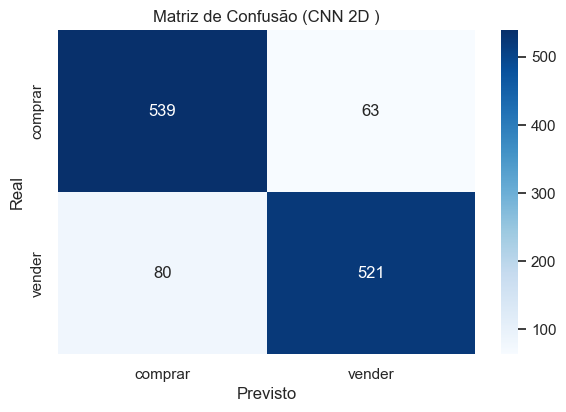


--- Relatório de Classificação (CNN 2D ) ---
              precision    recall  f1-score   support

     comprar       0.87      0.90      0.88       602
      vender       0.89      0.87      0.88       601

    accuracy                           0.88      1203
   macro avg       0.88      0.88      0.88      1203
weighted avg       0.88      0.88      0.88      1203


--- AUC Score (CNN 2D ) ---
AUC Score (calculado): 0.9551


In [22]:
print("Avaliando o modelo CNN 2D  no conjunto de teste...")

# Avalia o modelo
results = model.evaluate(test_ds, verbose=0, batch_size=BATCH_SIZE) # Usa BATCH_SIZE definido
loss = results[0]
accuracy = results[1]
auc_metric = results[2]

print(f"\n--- Resultados da Avaliação CNN 2D  (evaluate) ---")
print(f"Perda (Loss): {loss:.4f}")
print(f"Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC (da evaluate): {auc_metric:.4f}")

# Gera previsões para calcular métricas do sklearn
print("\nGerando previsões CNN 2D  no conjunto de teste...")
y_pred_proba_list = []
y_true_list = []
# Itera sobre o dataset de teste para obter todas as previsões e rótulos
for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred_proba_list.extend(preds.flatten())
    y_true_list.extend(labels.numpy().flatten())

y_pred_proba = np.array(y_pred_proba_list)
y_true = np.array(y_true_list).astype(int) # Labels reais

# Converte probabilidades em classes
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)
print(f"Usando limiar padrão: {threshold:.2f} para classificação.")

# Matriz de Confusão
print("\n--- Matriz de Confusão (CNN 2D ) ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
# Usa class_names obtido durante o carregamento dos dados
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto'); plt.ylabel('Real'); plt.title('Matriz de Confusão (CNN 2D )')
plt.show()

# Relatório de Classificação
print("\n--- Relatório de Classificação (CNN 2D ) ---")
# Usa class_names obtido durante o carregamento dos dados
report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)
print(report)

# AUC Score
print("\n--- AUC Score (CNN 2D ) ---")
try:
    roc_auc_score_val = roc_auc_score(y_true, y_pred_proba)
    print(f"AUC Score (calculado): {roc_auc_score_val:.4f}")
except ValueError as e: print(f"Não foi possível calcular AUC score: {e}")
except Exception as e: print(f"Erro ao calcular AUC Score: {e}")


## 5. Visualização dos Resultados (CNN 2D )

Visualizamos o histórico de treinamento e a curva ROC para o modelo CNN 2D.


Gerando gráficos de visualização para CNN 2D ...
Plotando histórico de treinamento...


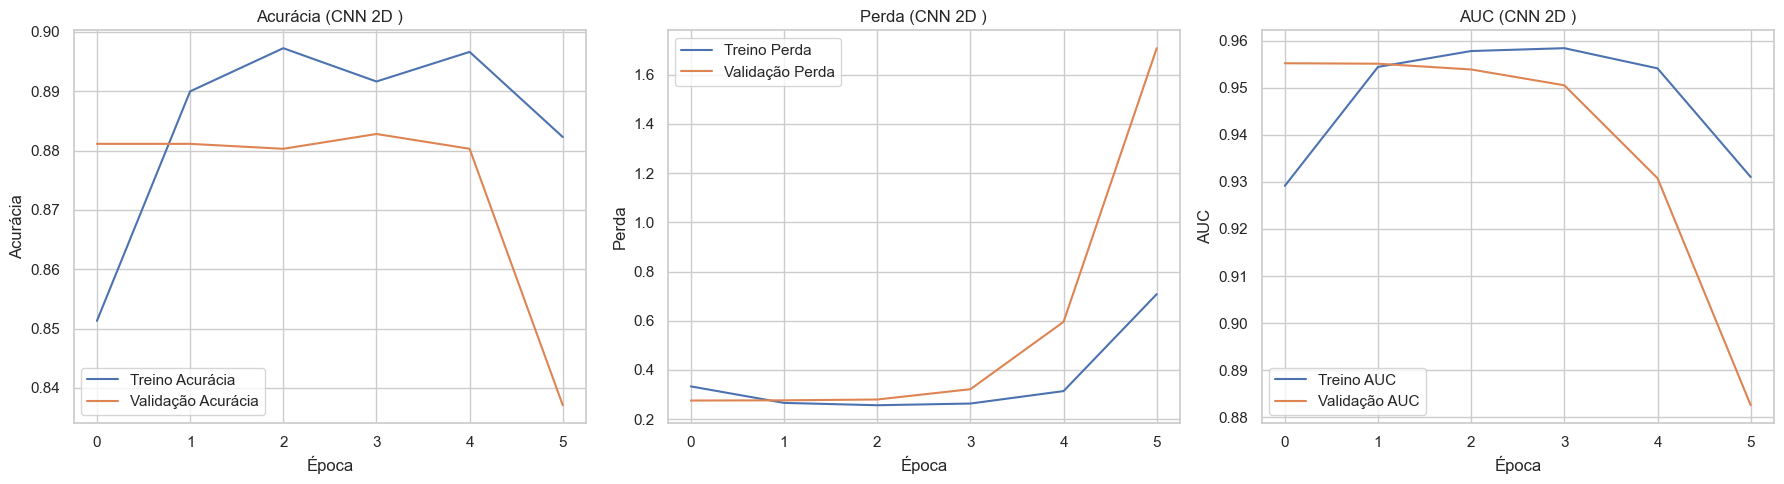

Plotando Curva ROC...


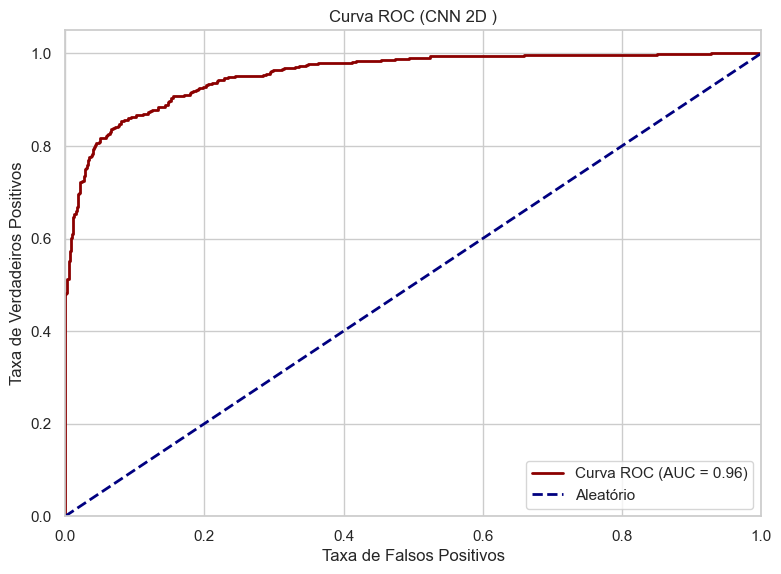

Plotando distribuição das probabilidades...


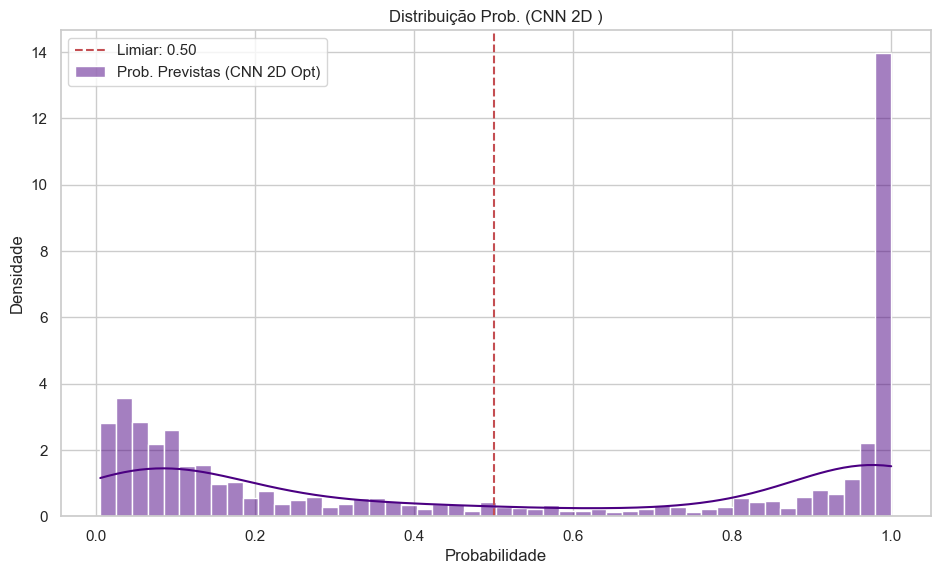

In [23]:
print("Gerando gráficos de visualização para CNN 2D ...")

# 1. Gráficos do Histórico de Treinamento
# Verifica se a variável history foi definida (o treinamento pode ter falhado)
if 'history' in locals() and history is not None and history.history:
    print("Plotando histórico de treinamento...")
    plt.figure(figsize=(18, 5))
    metrics_to_plot={'Acurácia':'accuracy','Perda':'loss','AUC':'auc'}
    i=1
    for display_name, metric_key in metrics_to_plot.items():
        if metric_key in history.history:
            plt.subplot(1,len(metrics_to_plot), i)
            plt.plot(history.history[metric_key],label=f'Treino {display_name}')
            val_metric_key=f'val_{metric_key}'
            if val_metric_key in history.history:
                plt.plot(history.history[val_metric_key],label=f'Validação {display_name}')
            plt.title(f'{display_name} (CNN 2D )'); plt.xlabel('Época'); plt.ylabel(display_name); plt.legend(); i+=1
    plt.tight_layout(); plt.savefig('cnn2d_opt_vale3_training_metrics.png'); plt.show()
else: print("Histórico de treinamento não disponível para plotagem.")

# 2. Gráfico da Curva ROC
if len(np.unique(y_true)) > 1: # Verifica se há mais de uma classe nos labels reais
    print("Plotando Curva ROC...")
    plt.figure(figsize=(8, 6))
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkred', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
        plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('Taxa de Falsos Positivos'); plt.ylabel('Taxa de Verdadeiros Positivos')
        plt.title('Curva ROC (CNN 2D )'); plt.legend(loc="lower right"); plt.grid(True); plt.savefig('cnn2d_opt_vale3_roc_curve.png'); plt.show()
    except Exception as e: print(f"Erro ao gerar curva ROC: {e}")
else: print("Curva ROC não gerada (necessita de ambas as classes no conjunto de teste).")

# 3. Gráfico da Distribuição das Probabilidades (Opcional, mas útil)
print("Plotando distribuição das probabilidades...")
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True, label='Prob. Previstas (CNN 2D Opt)', color='indigo', stat='density')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Limiar: {threshold:.2f}'); plt.title('Distribuição Prob. (CNN 2D )')
plt.xlabel('Probabilidade'); plt.ylabel('Densidade'); plt.legend(); plt.savefig('cnn2d_opt_vale3_prediction_distribution.png'); plt.show()


## 6. Salvamento do Modelo (CNN 2D )

Salvamos o modelo CNN 2D e treinado.


In [24]:
print("Salvando o modelo CNN 2D  treinado...")
MODEL_SAVE_PATH = 'models/vale3_cnn2d_model.keras'
H5_SAVE_PATH = 'models/vale3_cnn2d_model.h5' # Fallback

try:
    os.makedirs('models', exist_ok=True)
    model.save(MODEL_SAVE_PATH)
    print(f"Modelo salvo com sucesso em '{MODEL_SAVE_PATH}'")
    # Salvar HPs usados neste notebook
    best_hps_cnn2d_final = { # Recriando dict com os HPs usados
        'num_conv_blocks': HP_NUM_CONV_BLOCKS, 'filters_start': HP_FILTERS_START,
        'kernel_size': HP_KERNEL_SIZE, 'use_batchnorm': HP_USE_BATCHNORM,
        'dropout_rate': HP_DROPOUT_RATE, 'dense_units': HP_DENSE_UNITS,
        'learning_rate': HP_LEARNING_RATE
    }
    with open('models/cnn2d_final_hyperparameters.txt', 'w') as f:
        for hp_name, hp_value in best_hps_cnn2d_final.items():
            f.write(f"{hp_name}: {hp_value}\n")
    print("Hiperparâmetros usados salvos em 'models/cnn2d_final_hyperparameters.txt'")

except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")
    try:
        model.save(H5_SAVE_PATH)
        print(f"Modelo salvo no formato HDF5 em '{H5_SAVE_PATH}'")
    except Exception as e2:
        print(f"Erro ao salvar o modelo no formato HDF5: {e2}")

Salvando o modelo CNN 2D  treinado...
Modelo salvo com sucesso em 'models/vale3_cnn2d_model.keras'
Hiperparâmetros usados salvos em 'models/cnn2d_final_hyperparameters.txt'
